# DSCI 100 Group Project Proposal - Group 17

In [14]:
library(tidyverse)
library(tidymodels)
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)

set.seed(999)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Introduction

**delete when done!!!**

* Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
* Clearly state the question you will try to answer with your project
* Identify and describe the dataset that will be used to answer the question

Data source: https://archive.ics.uci.edu/ml/datasets/Audit+Data

Publication: https://www.researchgate.net/publication/323655455_Fraudulent_Firm_Classification_A_Case_Study_of_an_External_Audit

## Preliminary Exploratory Data Analysis

**delete when done!!!**

* Demonstrate that the dataset can be read from the web into R 
* Clean and wrangle your data into a tidy format
* Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
* Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.


**Dataset Info** 
- Obtained from publication https://www.researchgate.net/publication/323655455_Fraudulent_Firm_Classification_A_Case_Study_of_an_External_Audit

| | Inherent Risk Factors | | Control Risk Factors |
| --- | --- | ---| --- |
| ParaA | Discrepancy in planned-expenditure of inspection and summary report A in Rs | Sector score | Historical risk score value of the target-unit |
| ParaB | Discrepancy in unplanned-expenditure of inspection and summary report B in Rs | Loss | Amount of loss suffered by the firm last year. |
| Total | Total amount of discrepancy found in other reports Rs | History | Average historical loss suffered by firm in the last 10 years. |
| Number | Historical discrepancy score. | District score | Historical risk score of a district in the last 10 years. |
| Money Value | Amount of money involved in misstatements in the past audits. | | |
| Sector ID | Unique ID of the target sector. | Location ID | Unique ID of the city/province. |
| ARS | Total risk score using analytical procedure. | Audit ID | Unique Id assigned to an audit case. |
| Risk class | Risk Class assigned to an audit-case, 1=fraud or 0=no fraud (Target Feature) 

In [2]:
# import the data set, make column names consistent
url <- "https://raw.githubusercontent.com/hakkd/dsci-100-project-group17/main/trial.csv"

column_names = c("sector_score", "location_id", "para_a", "score_a", "para_b", "score_b", 
             "total", "numbers", "marks", "money_value", "money_marks", "district", "loss", 
             "loss_score", "history", "history_score", "score", "risk")

audit_data <- read_csv(url, col_names = column_names, skip = 1)

head(audit_data)

Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): location_id
dbl (17): sector_score, para_a, score_a, para_b, score_b, total, numbers, ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sector_score,location_id,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score,risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,6,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,6,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,1
3.89,6,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,0.83,2,0.83,5,2,2.95,2,2,0,2,0,2,2.0,0


In [3]:
# change Risk to factor and recode as F (fraud) or N (no fraud)
audit_data <- audit_data |>
        mutate(risk = as.factor(risk))

audit_data$risk <- ifelse(audit_data$risk == "1", "F", "N")

# check that output is correct
head(audit_data)

sector_score,location_id,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score,risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3.89,23,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,F
3.89,6,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,N
3.89,6,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,N
3.89,6,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,F
3.89,6,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,N
3.89,6,0.00,2,0.83,2,0.83,5,2,2.95,2,2,0,2,0,2,2.0,N


In [4]:
# creating training and testing datasets
audit_split <- initial_split(audit_data, prop = 0.75, strata = risk)

audit_train <- training(audit_split)
audit_test <- testing(audit_split)

In [5]:
# check proportion of fraudulent and not fraudulent cases
audit_proportions <- audit_train |>
                      group_by(risk) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(audit_train))

audit_proportions

risk,n,percent
<chr>,<int>,<dbl>
F,364,62.6506
N,217,37.3494


Based on the table above, this dataset has more fraudulent observations than not-fraudulent ones (~2:1)

In [6]:
# check how many NA values are in each column (if any)
audit_train |>
    map_df(is.na) |>
    map_df(sum)

sector_score,location_id,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score,risk
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


The data is mostly complete. Only the money_value column contains an NA value. We will need to account for the NA value if we do any operations on this column.

In [47]:
# show mean of all columns grouped by risk
audit_train |> 
    group_by(risk) |>
    summarize(across(sector_score:score , mean, na.rm = TRUE))

Warning message in mean.default(col, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(col, ...):
“argument is not numeric or logical: returning NA”


risk,sector_score,location_id,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F,14.31055,NA,3.6789852,4.335165,17.7437912,3.741758,21.3551940,5.10989,2.368132,23.3347527,3.428571,2.846154,0.05494505,2.115385,0.1428571,2.252747,3.093956
N,31.53065,NA,0.3056221,2.000000,0.2499889,2.000000,0.5556111,5.00000,2.000000,0.2232593,2.000000,2.000000,0.00000000,2.000000,0.0000000,2.000000,2.000000


Based on the output above showing column mean grouped by fraud and no fraud cases, we can see that there are large differences in the means of some of the variables. The greatest differences are in para_a, para_b and total (expenditure discrepancy) and money_value (money involved in misstatements). These variables will probably be good candidates for predictors in our classifier.

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”


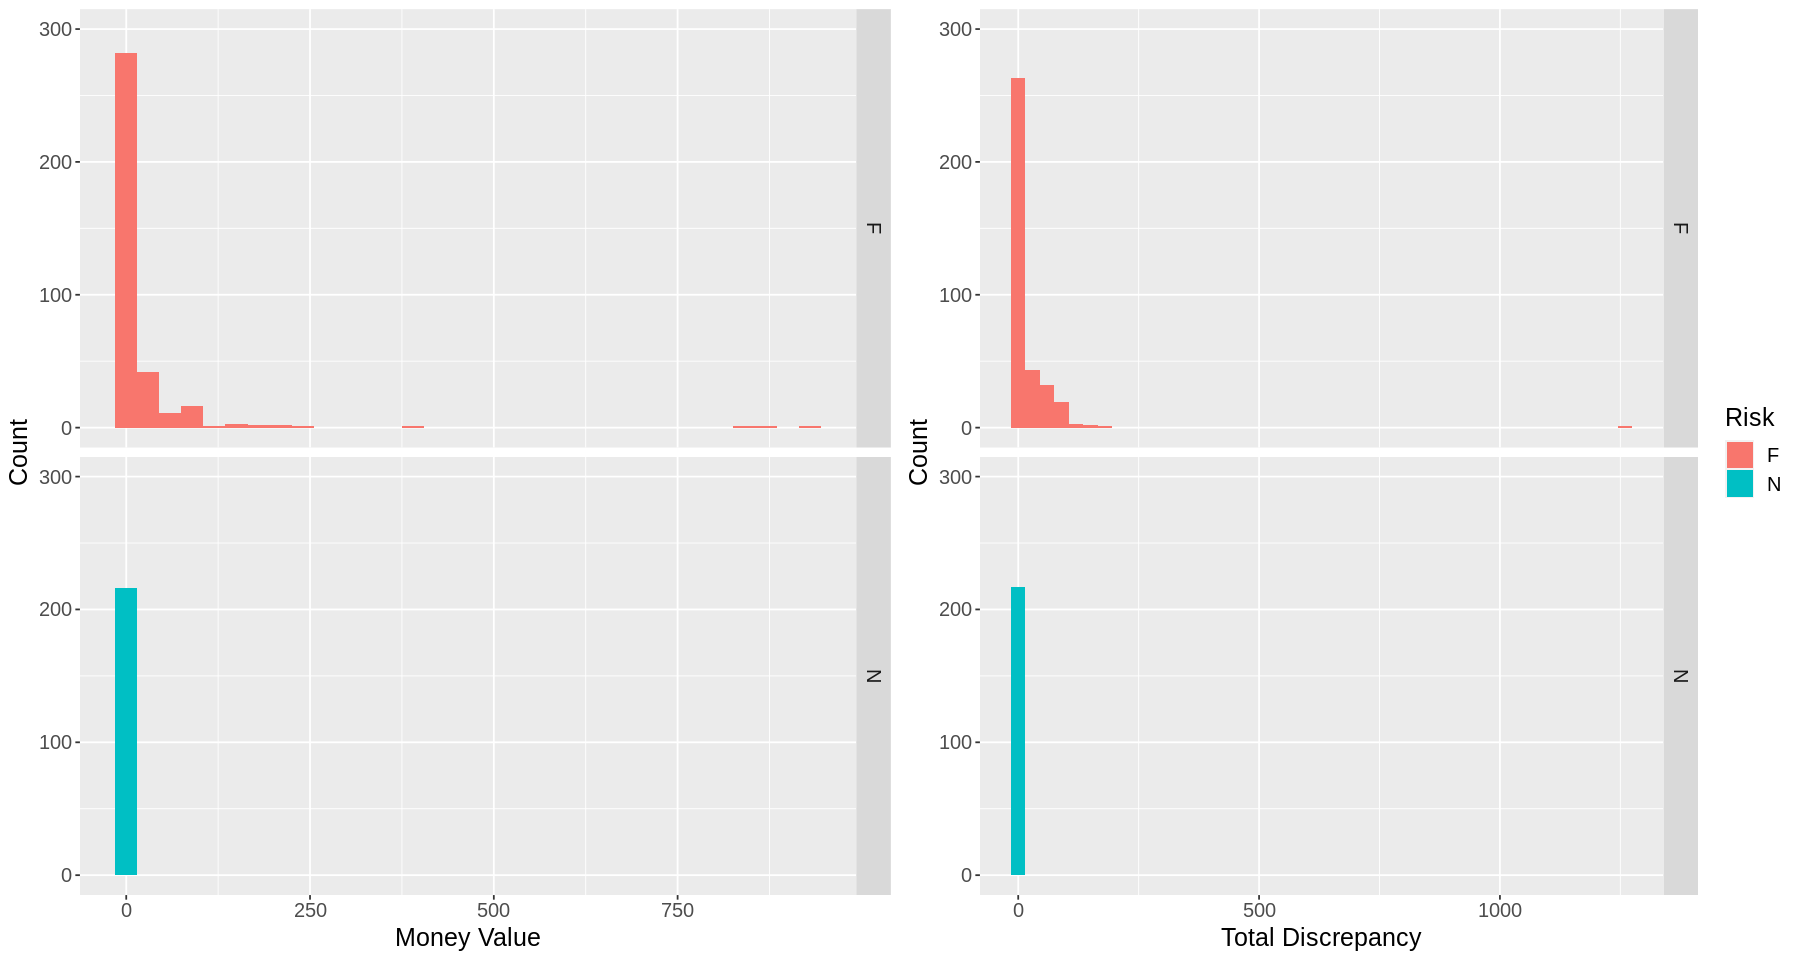

In [46]:
# visualize the distributions of the variables
options(repr.plot.width = 15, repr.plot.height = 8)

money_val_plot <- audit_train |>
        ggplot(aes(x = money_value, fill = risk)) + 
        geom_histogram(binwidth = 30, show.legend = FALSE) +
        scale_y_continuous(limits = c(0, 300)) +
        labs(x = "Money Value", y = "Count") +
        facet_grid(risk~.) + 
        theme(text = element_text(size = 15))

total_plot <- audit_train |>
        ggplot(aes(x = total, fill = risk)) + 
        geom_histogram(binwidth = 30) +
        scale_y_continuous(limits = c(0, 300)) +
        labs(x = "Total Discrepancy", y = "Count", fill = "Risk") +
        facet_grid(risk~.) + 
        theme(text = element_text(size = 15))

grid.arrange(total_plot, money_val_plot, nrow = 1)

Based on the plot above, we can see that the distributions of these data are quite skewed. Despite this, it looks like higher values of the money_value and total (discrepancy based on para_a and para_b) are associated with fraudulent cases. 

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


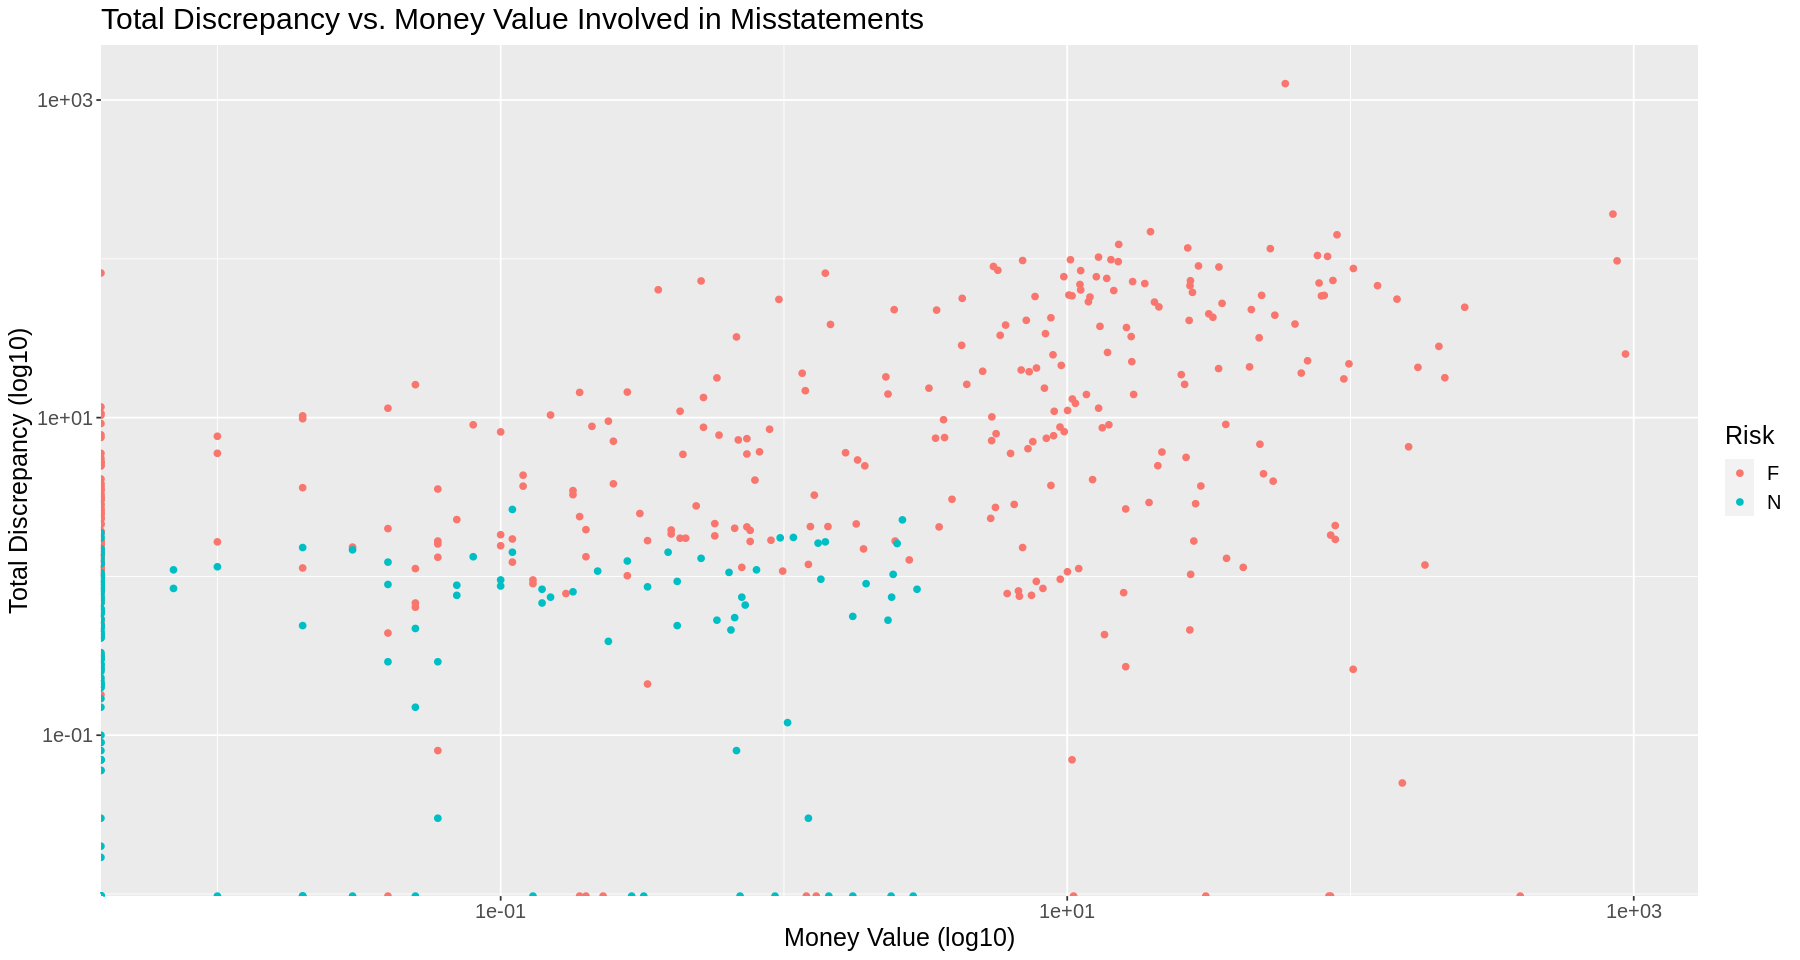

In [58]:
# make a scatter plot to compare the two variables of interest
audit_scatter <- audit_train |>
        ggplot(aes(x = money_value, y = total, colour = risk, fill = risk)) +
        geom_point() +
        scale_x_continuous(trans = "log10")+
        scale_y_continuous(trans = "log10") +
        labs(fill = "Risk", 
             colour = "Risk", 
             x = "Money Value (log10)", 
             y = "Total Discrepancy (log10)") +
        ggtitle("Total Discrepancy vs. Money Value Involved in Misstatements") +
        theme(text = element_text(size = 15))

audit_scatter

The scatterplot above shows that there are differences between the two risk groups with respect to the two variables shown. The data were skewed, so log axes are used. Higher values of total discrepancy and money value shown seem to correlate with fraudulent cases.

## Methods

**delete when done!!!**
* Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
* Describe at least one way that you will visualize the results

## Expected Outcomes and Significance

**delete when done!!!**
* What do you expect to find?
* What impact could such findings have?
* What future questions could this lead to?
